In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmedsalem200","key":"b8b7e1ca2832490c73551fff9938380f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip -d ./brain_tumor_data

Streaming output truncated to the last 5000 lines.
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0712.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0713.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0714.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0715.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0716.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0717.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0718.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0719.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0720.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0721.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0722.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0723.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0724.jpg  
  inflating: ./brain_tumor_data/Training/glioma/Tr-gl_0725.jpg  
  inflating: ./brain_tumor_data/Trainin

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from collections import defaultdict

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models, datasets

#Remove Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_dir = "/content/brain_tumor_data"
splits = ['Training', 'Testing']
target_size = (224, 224)
num_classes = 4
class_counts = defaultdict(int)

for split in splits:
    split_dir = os.path.join(data_dir, split)
    print(f"\nSplit: {split}")
    for cls in os.listdir(split_dir):
        cls_path = os.path.join(split_dir, cls)
        count = len(os.listdir(cls_path))
        class_counts[(split, cls)] = count
        print(f"  Class '{cls}': {count} images")


Split: Training
  Class 'pituitary': 1457 images
  Class 'notumor': 1595 images
  Class 'glioma': 1321 images
  Class 'meningioma': 1339 images

Split: Testing
  Class 'pituitary': 300 images
  Class 'notumor': 405 images
  Class 'glioma': 300 images
  Class 'meningioma': 306 images


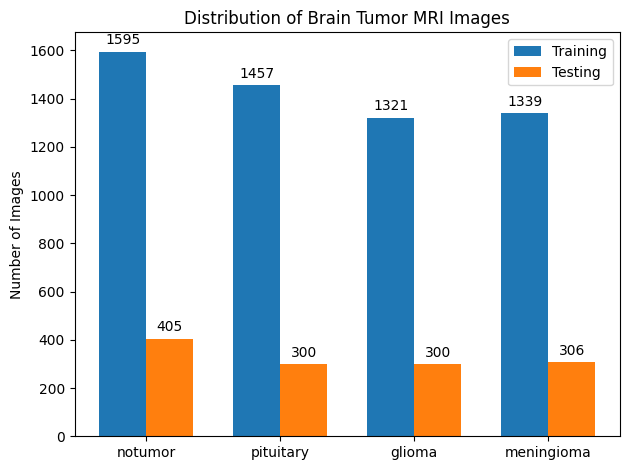

In [ ]:
#Data Visualization
labels = ['notumor', 'pituitary', 'glioma', 'meningioma']
training_data = [class_counts[('Training', label)] for label in labels]
testing_data = [class_counts[('Testing', label)] for label in labels]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_data, width, label='Training')
rects2 = ax.bar(x + width/2, testing_data, width, label='Testing')


ax.set_ylabel('Number of Images')
ax.set_title('Distribution of Brain Tumor MRI Images')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)# Show the count of each bar in the Training set.
ax.bar_label(rects2, padding=3)# show the count of each bar in the testing set.

fig.tight_layout()

plt.show()



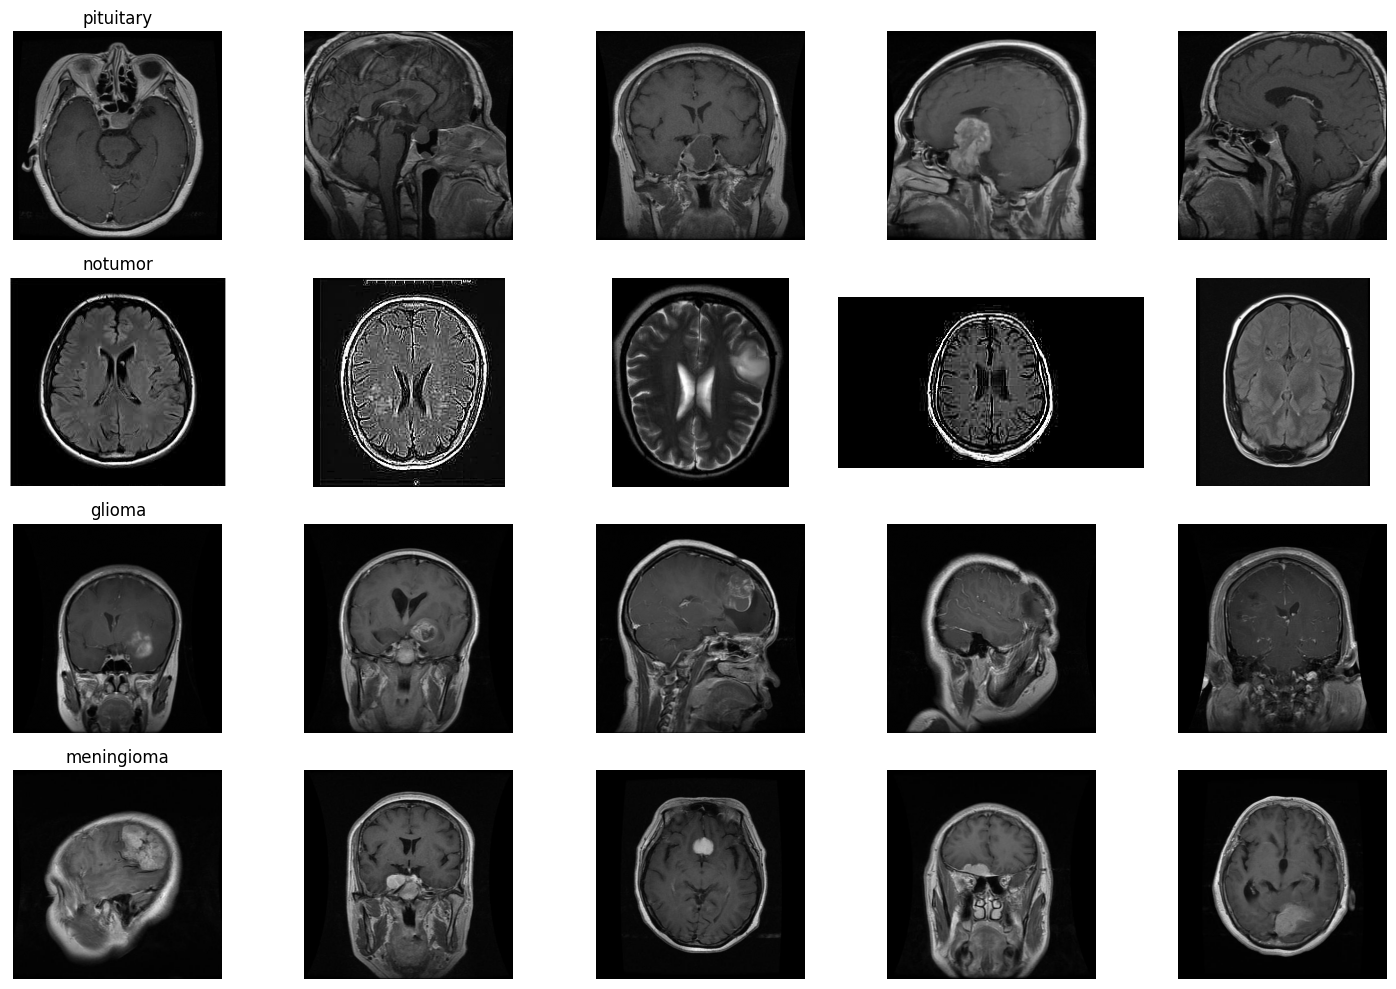

In [ ]:
def show_samples(split='Training', num_samples=5):
    split_path = os.path.join(data_dir, split)
    classes = os.listdir(split_path)

    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 10))
    for i, cls in enumerate(classes):
        cls_path = os.path.join(split_path, cls)
        images = os.listdir(cls_path)[:num_samples]
        for j in range(num_samples):
            img_path = os.path.join(cls_path, images[j])
            img = Image.open(img_path)
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(cls)
    plt.tight_layout()
    plt.show()

show_samples()


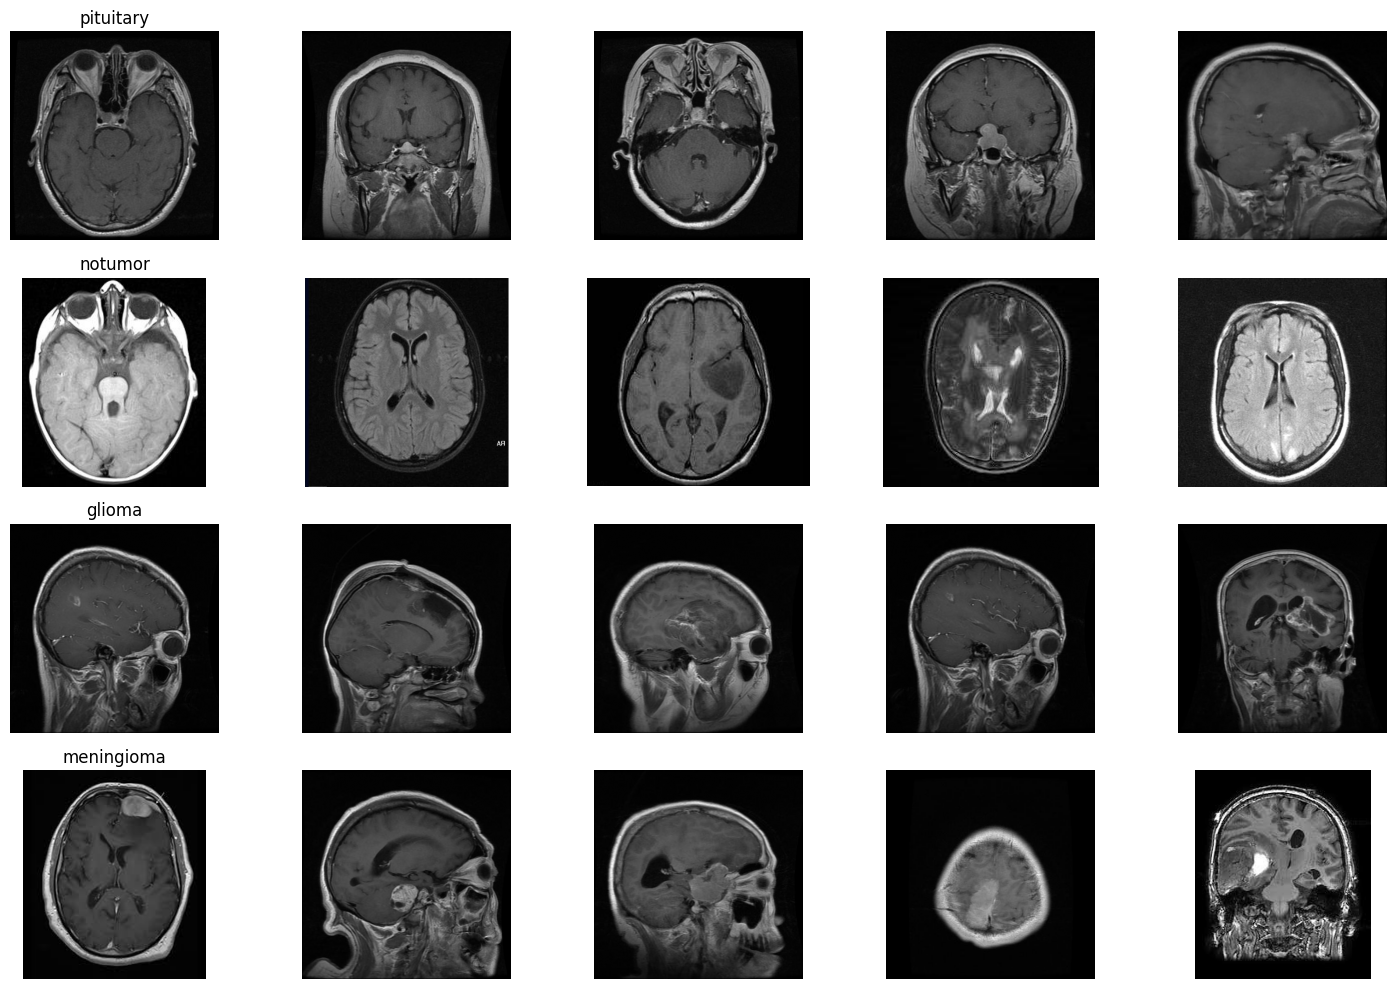

In [ ]:
def show_samples(split='Testing', num_samples=5):
    split_path = os.path.join(data_dir, split)
    classes = os.listdir(split_path)

    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 10))
    for i, cls in enumerate(classes):
        cls_path = os.path.join(split_path, cls)
        images = os.listdir(cls_path)[:num_samples]
        for j in range(num_samples):
            img_path = os.path.join(cls_path, images[j])
            img = Image.open(img_path)
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(cls)
    plt.tight_layout()
    plt.show()

show_samples()


In [ ]:
def create_dataset(path):
    my_list = []
    for category in labels:
        category_path = os.path.join(path, category)
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            # Ensure we're only adding image files
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                my_list.append([file_path, category])
    return pd.DataFrame(my_list, columns=['file_path', 'label'])

In [ ]:
train_df = create_dataset(data_dir+'/'+splits[0]) # Training
test_df = create_dataset(data_dir+'/'+splits[1]) # Testing

In [ ]:
label_map = {
    'notumor': 0,
    'glioma': 1,
    'meningioma': 2,
    'pituitary': 3
}
train_df['label'] = train_df['label'].map(label_map)
test_df['label'] = test_df['label'].map(label_map)

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
train_transform = transforms.Compose([

   transforms.Resize(target_size),
   transforms.RandomHorizontalFlip(),
   transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
   transforms.ColorJitter(brightness=(0.8, 1.2)),
   transforms.RandomRotation(10),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
test_df_split, val_df_split = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['label'])
# Reset indices for consistency
test_df_split = test_df_split.reset_index(drop=True)
val_df_split = val_df_split.reset_index(drop=True)

In [ ]:
train_dataset = ImageDataset(train_df, transform=train_transform)
val_dataset = ImageDataset(val_df_split, transform=test_transform)
test_dataset = ImageDataset(test_df_split, transform=test_transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # Conv Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   # (B, 32, 224, 224)

        # Conv Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (B, 64, 112, 112)

        # Conv Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # (B, 128, 56, 56)

        # Conv Block 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # (B, 256, 28, 28)

        # Conv Block 5
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # (B, 256, 14, 14)

        # Final shape after pool: (B, 256, 7, 7)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # (B, 32, 112, 112)
        x = self.pool(self.relu(self.conv2(x)))  # (B, 64, 56, 56)
        x = self.pool(self.relu(self.conv3(x)))  # (B, 128, 28, 28)
        x = self.pool(self.relu(self.conv4(x)))  # (B, 256, 14, 14)
        x = self.pool(self.relu(self.conv5(x)))  # (B, 256, 7, 7)

        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BrainTumorCNN(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

In [ ]:
from tqdm import tqdm

In [ ]:
print("üöÄ Start model training...")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_val_loss = float('inf')
tolerance = 0
patience = 7
num_epochs =70



history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(1, num_epochs + 1):
    # Training phase
    model.train()
    epoch_loss = 0.0
    correct_train = 0
    total_train = 0

    with tqdm(total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}") as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()


            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            pbar.update(1)

    train_loss = epoch_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct_val / total_val
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)




    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'best_brain_tumor_{"model"}.pth')
        print(f"üì¢ Epoch {epoch}:")
        print(f"üì¢ Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.2f}%")
        print(f"üì¢ Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.2f}%")
        print(" " * 80)
        print(f"‚úÖ Best model saved at epoch {epoch} with Val Loss: {val_loss:.4f}")
        print(" " * 80)
        print("üìå" * 25)
        tolerance = 0
    else:
        tolerance += 1
        print(f"‚ö†Ô∏è Epoch {epoch}:")
        print(f"‚ö†Ô∏è Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.2f}%")
        print(f"‚ö†Ô∏è Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.2f}%")
        print(" " * 80)
        print("üìå" * 25)
        print(" " * 80)
        if tolerance >= patience:
            print(f"‚èπÔ∏è Early stopping triggered at epoch {epoch}")
            break

print("üéâ Training complete!")

üöÄ Start model training...


Epoch 1/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:48<00:00,  3.66it/s]


üì¢ Epoch 1:
üì¢ Train Loss = 0.2582, Train Acc = 91.09%
üì¢ Val Loss = 0.3930, Val Acc = 84.60%
                                                                                
‚úÖ Best model saved at epoch 1 with Val Loss: 0.3930
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå


Epoch 2/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:49<00:00,  3.59it/s]


üì¢ Epoch 2:
üì¢ Train Loss = 0.2404, Train Acc = 91.46%
üì¢ Val Loss = 0.3128, Val Acc = 87.65%
                                                                                
‚úÖ Best model saved at epoch 2 with Val Loss: 0.3128
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå


Epoch 3/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:48<00:00,  3.72it/s]


üì¢ Epoch 3:
üì¢ Train Loss = 0.2104, Train Acc = 92.73%
üì¢ Val Loss = 0.2208, Val Acc = 92.07%
                                                                                
‚úÖ Best model saved at epoch 3 with Val Loss: 0.2208
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå


Epoch 4/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:48<00:00,  3.72it/s]


‚ö†Ô∏è Epoch 4:
‚ö†Ô∏è Train Loss = 0.1926, Train Acc = 93.38%
‚ö†Ô∏è Val Loss = 0.2460, Val Acc = 92.23%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                


Epoch 5/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:49<00:00,  3.58it/s]


üì¢ Epoch 5:
üì¢ Train Loss = 0.1900, Train Acc = 93.79%
üì¢ Val Loss = 0.1895, Val Acc = 92.84%
                                                                                
‚úÖ Best model saved at epoch 5 with Val Loss: 0.1895
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå


Epoch 6/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:48<00:00,  3.71it/s]


‚ö†Ô∏è Epoch 6:
‚ö†Ô∏è Train Loss = 0.1840, Train Acc = 93.64%
‚ö†Ô∏è Val Loss = 0.1988, Val Acc = 92.53%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                


Epoch 7/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:50<00:00,  3.58it/s]


‚ö†Ô∏è Epoch 7:
‚ö†Ô∏è Train Loss = 0.1655, Train Acc = 94.57%
‚ö†Ô∏è Val Loss = 0.2006, Val Acc = 93.90%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                


Epoch 8/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:50<00:00,  3.57it/s]


üì¢ Epoch 8:
üì¢ Train Loss = 0.1582, Train Acc = 94.63%
üì¢ Val Loss = 0.1107, Val Acc = 96.49%
                                                                                
‚úÖ Best model saved at epoch 8 with Val Loss: 0.1107
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå


Epoch 9/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:49<00:00,  3.65it/s]


‚ö†Ô∏è Epoch 9:
‚ö†Ô∏è Train Loss = 0.1487, Train Acc = 95.24%
‚ö†Ô∏è Val Loss = 0.1232, Val Acc = 94.82%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                


Epoch 10/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:58<00:00,  3.08it/s]


üì¢ Epoch 10:
üì¢ Train Loss = 0.1447, Train Acc = 95.03%
üì¢ Val Loss = 0.0912, Val Acc = 96.80%
                                                                                
‚úÖ Best model saved at epoch 10 with Val Loss: 0.0912
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå


Epoch 11/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:48<00:00,  3.72it/s]


‚ö†Ô∏è Epoch 11:
‚ö†Ô∏è Train Loss = 0.1380, Train Acc = 95.69%
‚ö†Ô∏è Val Loss = 0.1530, Val Acc = 95.12%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                


Epoch 12/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:50<00:00,  3.54it/s]


‚ö†Ô∏è Epoch 12:
‚ö†Ô∏è Train Loss = 0.1156, Train Acc = 96.34%
‚ö†Ô∏è Val Loss = 0.1183, Val Acc = 96.95%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                


Epoch 13/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:48<00:00,  3.69it/s]


‚ö†Ô∏è Epoch 13:
‚ö†Ô∏è Train Loss = 0.1073, Train Acc = 96.36%
‚ö†Ô∏è Val Loss = 0.1697, Val Acc = 94.51%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                


Epoch 14/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:48<00:00,  3.66it/s]


üì¢ Epoch 14:
üì¢ Train Loss = 0.1146, Train Acc = 96.17%
üì¢ Val Loss = 0.0699, Val Acc = 98.02%
                                                                                
‚úÖ Best model saved at epoch 14 with Val Loss: 0.0699
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå


Epoch 15/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:49<00:00,  3.65it/s]


‚ö†Ô∏è Epoch 15:
‚ö†Ô∏è Train Loss = 0.1045, Train Acc = 96.62%
‚ö†Ô∏è Val Loss = 0.0896, Val Acc = 96.95%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                


Epoch 16/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:49<00:00,  3.64it/s]


‚ö†Ô∏è Epoch 16:
‚ö†Ô∏è Train Loss = 0.1045, Train Acc = 96.64%
‚ö†Ô∏è Val Loss = 0.0927, Val Acc = 98.17%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                


Epoch 17/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:49<00:00,  3.59it/s]


‚ö†Ô∏è Epoch 17:
‚ö†Ô∏è Train Loss = 0.0958, Train Acc = 96.85%
‚ö†Ô∏è Val Loss = 0.2301, Val Acc = 92.84%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                


Epoch 18/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:47<00:00,  3.74it/s]


‚ö†Ô∏è Epoch 18:
‚ö†Ô∏è Train Loss = 0.0872, Train Acc = 97.22%
‚ö†Ô∏è Val Loss = 0.0783, Val Acc = 97.71%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                


Epoch 19/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:47<00:00,  3.75it/s]


‚ö†Ô∏è Epoch 19:
‚ö†Ô∏è Train Loss = 0.0884, Train Acc = 97.32%
‚ö†Ô∏è Val Loss = 0.0840, Val Acc = 97.26%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                


Epoch 20/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:49<00:00,  3.62it/s]


üì¢ Epoch 20:
üì¢ Train Loss = 0.0691, Train Acc = 97.51%
üì¢ Val Loss = 0.0588, Val Acc = 98.32%
                                                                                
‚úÖ Best model saved at epoch 20 with Val Loss: 0.0588
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå


Epoch 21/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:49<00:00,  3.60it/s]


üì¢ Epoch 21:
üì¢ Train Loss = 0.0824, Train Acc = 97.44%
üì¢ Val Loss = 0.0524, Val Acc = 98.78%
                                                                                
‚úÖ Best model saved at epoch 21 with Val Loss: 0.0524
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå


Epoch 22/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:50<00:00,  3.57it/s]


‚ö†Ô∏è Epoch 22:
‚ö†Ô∏è Train Loss = 0.0732, Train Acc = 97.62%
‚ö†Ô∏è Val Loss = 0.0745, Val Acc = 98.48%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                


Epoch 23/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:49<00:00,  3.61it/s]


‚ö†Ô∏è Epoch 23:
‚ö†Ô∏è Train Loss = 0.0754, Train Acc = 97.99%
‚ö†Ô∏è Val Loss = 0.0952, Val Acc = 97.41%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                


Epoch 24/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:49<00:00,  3.59it/s]


‚ö†Ô∏è Epoch 24:
‚ö†Ô∏è Train Loss = 0.0587, Train Acc = 98.25%
‚ö†Ô∏è Val Loss = 0.1062, Val Acc = 97.10%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                


Epoch 25/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:49<00:00,  3.58it/s]


üì¢ Epoch 25:
üì¢ Train Loss = 0.0714, Train Acc = 98.20%
üì¢ Val Loss = 0.0476, Val Acc = 99.09%
                                                                                
‚úÖ Best model saved at epoch 25 with Val Loss: 0.0476
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå


Epoch 26/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:48<00:00,  3.66it/s]


‚ö†Ô∏è Epoch 26:
‚ö†Ô∏è Train Loss = 0.0613, Train Acc = 97.79%
‚ö†Ô∏è Val Loss = 0.1017, Val Acc = 98.02%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                


Epoch 27/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:49<00:00,  3.59it/s]


‚ö†Ô∏è Epoch 27:
‚ö†Ô∏è Train Loss = 0.0708, Train Acc = 97.88%
‚ö†Ô∏è Val Loss = 0.0849, Val Acc = 97.56%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                


Epoch 28/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:47<00:00,  3.75it/s]


‚ö†Ô∏è Epoch 28:
‚ö†Ô∏è Train Loss = 0.0567, Train Acc = 98.18%
‚ö†Ô∏è Val Loss = 0.0533, Val Acc = 99.09%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                


Epoch 29/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:47<00:00,  3.75it/s]


üì¢ Epoch 29:
üì¢ Train Loss = 0.0714, Train Acc = 97.79%
üì¢ Val Loss = 0.0395, Val Acc = 98.48%
                                                                                
‚úÖ Best model saved at epoch 29 with Val Loss: 0.0395
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå


Epoch 30/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:49<00:00,  3.61it/s]


‚ö†Ô∏è Epoch 30:
‚ö†Ô∏è Train Loss = 0.0534, Train Acc = 98.27%
‚ö†Ô∏è Val Loss = 0.0787, Val Acc = 98.32%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                


Epoch 31/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:48<00:00,  3.67it/s]


‚ö†Ô∏è Epoch 31:
‚ö†Ô∏è Train Loss = 0.0673, Train Acc = 97.97%
‚ö†Ô∏è Val Loss = 0.1082, Val Acc = 97.87%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                


Epoch 32/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:49<00:00,  3.60it/s]


‚ö†Ô∏è Epoch 32:
‚ö†Ô∏è Train Loss = 0.0521, Train Acc = 98.48%
‚ö†Ô∏è Val Loss = 0.0847, Val Acc = 97.87%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                


Epoch 33/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:48<00:00,  3.72it/s]


‚ö†Ô∏è Epoch 33:
‚ö†Ô∏è Train Loss = 0.0541, Train Acc = 98.48%
‚ö†Ô∏è Val Loss = 0.0547, Val Acc = 98.93%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                


Epoch 34/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:47<00:00,  3.77it/s]


‚ö†Ô∏è Epoch 34:
‚ö†Ô∏è Train Loss = 0.0655, Train Acc = 98.55%
‚ö†Ô∏è Val Loss = 0.0659, Val Acc = 98.48%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                


Epoch 35/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:48<00:00,  3.68it/s]


‚ö†Ô∏è Epoch 35:
‚ö†Ô∏è Train Loss = 0.0533, Train Acc = 98.60%
‚ö†Ô∏è Val Loss = 0.0736, Val Acc = 98.63%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                


Epoch 36/70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 179/179 [00:48<00:00,  3.69it/s]


‚ö†Ô∏è Epoch 36:
‚ö†Ô∏è Train Loss = 0.0467, Train Acc = 98.74%
‚ö†Ô∏è Val Loss = 0.0540, Val Acc = 99.09%
                                                                                
üìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìåüìå
                                                                                
‚èπÔ∏è Early stopping triggered at epoch 36
üéâ Training complete!


In [ ]:
def plot_training_history(history, model_name="model"):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

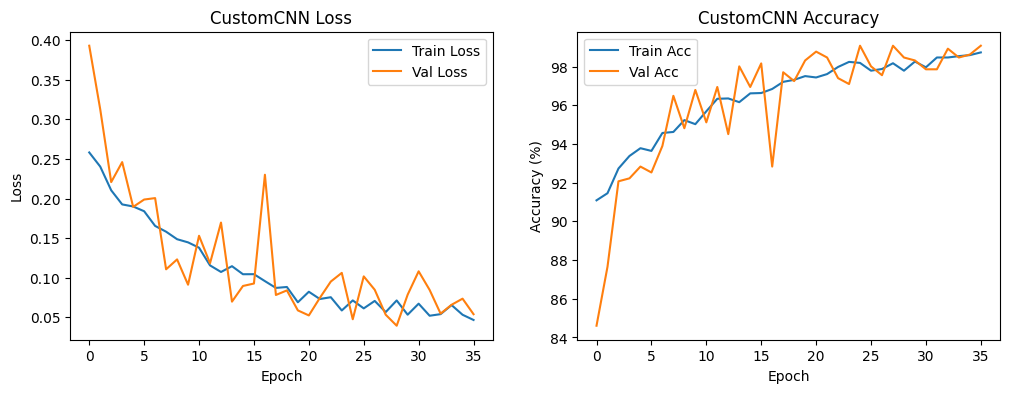

In [ ]:
plot_training_history(history, model_name="CustomCNN")

In [ ]:
def test_model(model, test_loader, num_images_to_show=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    all_preds = []
    all_labels = []
    all_images = []


    labels = ['notumor', 'glioma', 'meningioma', 'pituitary']
    with torch.no_grad():
        for images, labels_batch in test_loader:
            images, labels_batch = images.to(device), labels_batch.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels_batch.size(0)
            correct += (predicted == labels_batch).sum().item()

            # Collect for later analysis
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())
            all_images.extend(images.cpu())  # Store images for visualization

    test_acc = 100 * correct / total

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test Accuracy: {test_acc:.2f}%\n")

    # Print classification report
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=labels))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


Loading best model for testing...
Test Accuracy: 98.32%

Classification Report:

              precision    recall  f1-score   support

     notumor       0.97      1.00      0.98       202
      glioma       0.99      0.99      0.99       150
  meningioma       0.97      0.97      0.97       153
   pituitary       1.00      0.98      0.99       150

    accuracy                           0.98       655
   macro avg       0.98      0.98      0.98       655
weighted avg       0.98      0.98      0.98       655



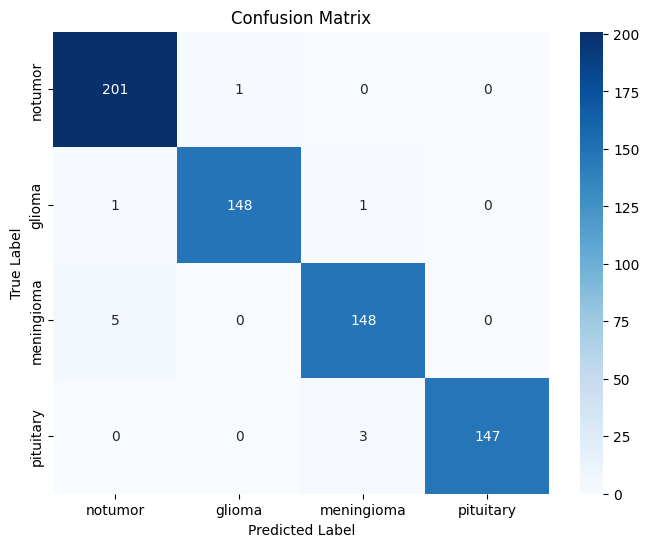

In [ ]:
print("\nLoading best model for testing...")
model.load_state_dict(torch.load('best_brain_tumor_model.pth'))
test_model(model, test_loader)